<H1 align="middle">Extreme Gradient Boost for Disease Spread Prediction</H1>

<br>
<strong>This notebook trains a extreme gradient boost-based classification model on the training dataset and predicts on the testing dataset</strong>

In [1]:
import xgboost as xgb
import dask.array as da
from dask.distributed import Client

from utils_data import *
from utils_evaluation import evaluate_numpy
from utils_plot import plot_confusion_matrix, plot_roc

In [2]:
# Initialize a Dask cluster
client = Client()

In [3]:
data = PopulationData().load_raw('../../data/raw/train.csv')
data.encode_normalized_age()
data.encode_normalized_constitution()
data.encode_normalized_behavior()
# data.encode_standardized_age()
# data.encode_standardized_constitution()
# data.encode_standardized_behavior()
data.encode_connection_lists()
data.encode_graph_nx()
data.encode_degree()
# data.encode_degree_centrality()
# data.encode_clustering_coefficient()
data.encode_normalized_degree()
# data.encode_normalized_degree_centrality()
# data.encode_normalized_clustering_coefficient()
# data.encode_standardized_degree()
# data.encode_standardized_degree_centrality()
# data.encode_standardized_clustering_coefficient()
# data.encode_connected_index_patient()
data.encode_distance_to_index_patient()
data.encode_normalized_distance_to_index_patient()
# data.encode_standardized_distance_to_index_patient()
data.encode_sum_neighbor_age()
data.encode_sum_neighbor_constitution()
data.encode_sum_neighbor_behavior()
data.encode_sum_neighbor_degree()
# data.encode_sum_neighbor_degree_centrality()
# data.encode_sum_neighbor_clustering_coefficient()
data.encode_normalized_sum_neighbor_age()
data.encode_normalized_sum_neighbor_constitution()
data.encode_normalized_sum_neighbor_behavior()
data.encode_normalized_sum_neighbor_degree()
# data.encode_normalized_sum_neighbor_degree_centrality()
# data.encode_normalized_sum_neighbor_clustering_coefficient()
# data.encode_standardized_sum_neighbor_age()
# data.encode_standardized_sum_neighbor_constitution()
# data.encode_standardized_sum_neighbor_behavior()
# data.encode_standardized_sum_neighbor_degree()
# data.encode_standardized_sum_neighbor_degree_centrality()
# data.encode_standardized_sum_neighbor_clustering_coefficient()
# data.encode_mean_neighbor_age()
# data.encode_mean_neighbor_constitution()
# data.encode_mean_neighbor_behavior()
# data.encode_mean_neighbor_degree()
# data.encode_mean_neighbor_degree_centrality()
# data.encode_mean_neighbor_clustering_coefficient()
# data.encode_normalized_mean_neighbor_age()
# data.encode_normalized_mean_neighbor_constitution()
# data.encode_normalized_mean_neighbor_behavior()
# data.encode_normalized_mean_neighbor_degree()
# data.encode_normalized_mean_neighbor_degree_centrality()
# data.encode_normalized_mean_neighbor_clustering_coefficient()
# data.encode_standardized_mean_neighbor_age()
# data.encode_standardized_mean_neighbor_constitution()
# data.encode_standardized_mean_neighbor_behavior()
# data.encode_standardized_mean_neighbor_degree()
# data.encode_standardized_mean_neighbor_degree_centrality()
# data.encode_standardized_mean_neighbor_clustering_coefficient()
data.encode_sum_population_age()
data.encode_sum_population_constitution()
data.encode_sum_population_behavior()
# data.encode_sum_population_degree()
# data.encode_sum_population_degree_centrality()
# data.encode_sum_population_clustering_coefficient()
data.encode_normalized_sum_population_age()
data.encode_normalized_sum_population_constitution()
data.encode_normalized_sum_population_behavior()
# data.encode_normalized_sum_population_degree()
# data.encode_normalized_sum_population_degree_centrality()
# data.encode_normalized_sum_population_clustering_coefficient()
# data.encode_standardized_sum_population_age()
# data.encode_standardized_sum_population_constitution()
# data.encode_standardized_sum_population_behavior()
# data.encode_standardized_sum_population_degree()
# data.encode_standardized_sum_population_degree_centrality()
# data.encode_standardized_sum_population_clustering_coefficient()
# data.encode_mean_population_age()
# data.encode_mean_population_constitution()
# data.encode_mean_population_behavior()
# data.encode_mean_population_degree()
# data.encode_mean_population_degree_centrality()
# data.encode_mean_population_clustering_coefficient()
# data.encode_normalized_mean_population_age()
# data.encode_normalized_mean_population_constitution()
# data.encode_normalized_mean_population_behavior()
# data.encode_normalized_mean_population_degree()
# data.encode_normalized_mean_population_degree_centrality()
# data.encode_normalized_mean_population_clustering_coefficient()
# data.encode_standardized_mean_population_age()
# data.encode_standardized_mean_population_constitution()
# data.encode_standardized_mean_population_behavior()
# data.encode_standardized_mean_population_degree()
# data.encode_standardized_mean_population_degree_centrality()
# data.encode_standardized_mean_population_clustering_coefficient()
data.encode_sum_population_distance_to_index_patient()
data.encode_normalized_sum_population_distance_to_index_patient()
# data.encode_standardized_sum_population_distance_to_index_patient()
# data.encode_mean_population_distance_to_index_patient()
# data.encode_normalized_mean_population_distance_to_index_patient()
# data.encode_standardized_mean_population_distance_to_index_patient()
data.encode_train_eval()

In [4]:
features = ['Normalized_Age',
			'Normalized_Behaviour',
			'Normalized_Constitution',
			'Normalized_Degree',
			'Normalized_Distance_to_Index_Patient',
			'Normalized_Sum_Neighbor_Age',
			'Normalized_Sum_Neighbor_Behaviour',
			'Normalized_Sum_Neighbor_Constitution',
			'Normalized_Sum_Neighbor_Degree',
			'Normalized_Sum_Population_Age',
			'Normalized_Sum_Population_Behaviour',
			'Normalized_Sum_Population_Constitution',
			'Normalized_Sum_Population_Distance_to_Index_Patient']
train_features, train_labels = data.get_feature_label_numpy(features=features, train='Train')
test_features, test_labels = data.get_feature_label_numpy(features=features, train='Test')

In [5]:
train_features = da.from_array(train_features, chunks=1000)
test_features = da.from_array(test_features, chunks=1000)
train_labels = da.from_array(train_labels, chunks=1000)
test_labels = da.from_array(test_labels, chunks=1000)

In [6]:
# Create Dask DMatrix
dtrain = xgb.dask.DaskDMatrix(client, train_features, train_labels)
dtest = xgb.dask.DaskDMatrix(client, test_features, test_labels)

Windows is not officially supported for dask/xgboost, contribution are welcomed.
C:\Users\Zhou\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
C:\Users\Zhou\AppData\Local\Programs\Python\Python311\Lib\site-packages\distributed\client.py:3166: UserWarning: Sending large graph of size 51.60 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Windows is not officially supported for dask/xgboost, contribution are welcomed.
C:\Users\Zhou\AppData\Local\Programs\Python\Python311\Lib\site-packages\distributed\client.py:3166: UserWarning: Sending large graph of size 12.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using

In [7]:
# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'error',
    'n_estimators': 200
}

# Train XGBoost model
model = xgb.XGBClassifier(**params, use_label_encoder=False)
model.fit(train_features, train_labels, eval_set=[(test_features, test_labels)], verbose=True)

[0]	validation_0-error:0.39856
[1]	validation_0-error:0.29721
[2]	validation_0-error:0.26272
[3]	validation_0-error:0.23470
[4]	validation_0-error:0.22583


C:\Users\Zhou\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-error:0.22208
[6]	validation_0-error:0.21512
[7]	validation_0-error:0.20916
[8]	validation_0-error:0.20612
[9]	validation_0-error:0.20629
[10]	validation_0-error:0.20588
[11]	validation_0-error:0.20512
[12]	validation_0-error:0.20505
[13]	validation_0-error:0.20332
[14]	validation_0-error:0.20282
[15]	validation_0-error:0.20285
[16]	validation_0-error:0.20261
[17]	validation_0-error:0.20313
[18]	validation_0-error:0.20303
[19]	validation_0-error:0.20272
[20]	validation_0-error:0.20238
[21]	validation_0-error:0.20178
[22]	validation_0-error:0.20118
[23]	validation_0-error:0.20122
[24]	validation_0-error:0.20079
[25]	validation_0-error:0.20095
[26]	validation_0-error:0.20079
[27]	validation_0-error:0.20065
[28]	validation_0-error:0.20002
[29]	validation_0-error:0.20008
[30]	validation_0-error:0.19988
[31]	validation_0-error:0.20025
[32]	validation_0-error:0.19978
[33]	validation_0-error:0.19999
[34]	validation_0-error:0.19992
[35]	validation_0-error:0.19992
[36]	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='error',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [8]:
test_predicted = model.predict(test_features)
test_probabilities = model.predict_proba(test_features)
test_probabilities = test_probabilities[:, 1]
accuracy, precision, recall, f1, auc_roc, confusion_matrix = evaluate_numpy(test_predicted, test_probabilities, test_labels)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')

Accuracy: 0.8019
Precision: 0.7266
Recall: 0.9236
F1: 0.8134
AUC-ROC: 0.8723


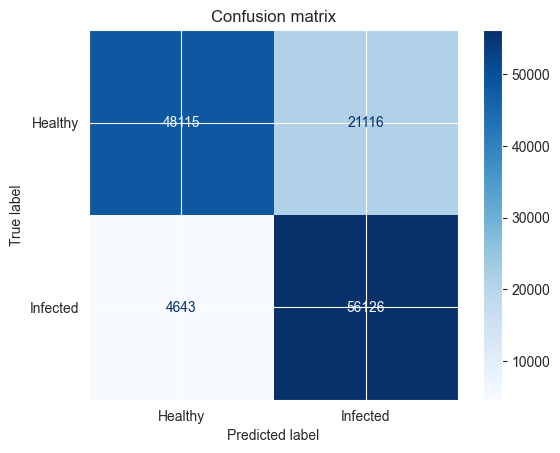

In [9]:
plot_confusion_matrix(confusion_matrix, ['Healthy', 'Infected'])

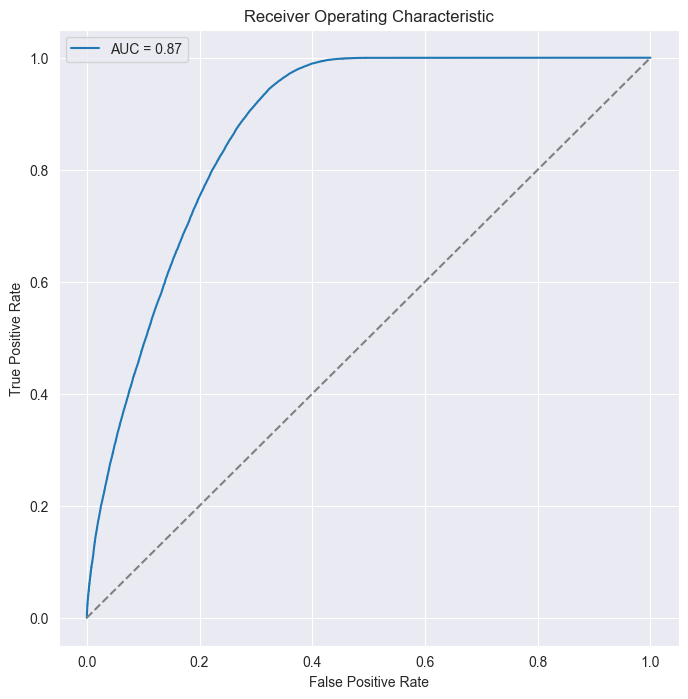

In [10]:
plot_roc(test_probabilities, test_labels)

In [12]:
model.save_model("../../models/xgb_model.json")